# Hydropower Atlas vs Utility Data –  Capacity factor comparison

This notebook compares utility-provided data with the Hydropower Atlas to identify any major differences in seasonal capacity factors across powerplants.

## Goal
- Visually compare capacity factors by season for each hydropower plant.
- Use different lines for each source (e.g., utility vs Hydropower Atlas).
- Include uncertainty bands if "dry" and "wet" years are available.

##  Expected Input Format
The input CSV should:
- Have a multi-index with three columns: `Powerplant`, `Source`, `year`
- Use `year` values like `"average"`, `"dry"`, `"wet"`
- Columns must be time slices (e.g., `season1`, `season2`, or months)
- If starting from Hydropower Atlas, preprocessing may be needed to:
  - Aggregate months into seasons
  - Harmonize naming of plants/sources with the EPM data


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:


def plot_capacity_factors_by_plant(csv_path, index_cols=("Powerplant", "Source", "year")):
    # Load data
    df = pd.read_csv(csv_path, index_col=list(range(3)))
    df = df.sort_index()

    # Extract unique seasons
    seasons = df.columns.tolist()

    # Filter average, dry, and wet
    df_avg = df.xs("average", level="year")
    df_dry = df[df.index.get_level_values("year") == "dry"]
    df_wet = df[df.index.get_level_values("year") == "wet"]

    # Identify unique sources and powerplants
    sources = df.index.get_level_values("Source").unique()
    plants = df.index.get_level_values("Powerplant").unique()

    # Color map for sources
    colors = plt.cm.tab10.colors
    color_map = {source: colors[i % len(colors)] for i, source in enumerate(sources)}

    # Prepare subplots
    n_plants = len(plants)
    ncols = 2
    nrows = (n_plants + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows), sharey=True)
    axes = axes.flatten()

    for idx, plant in enumerate(plants):
        ax = axes[idx]
        plant_avg = df_avg.loc[plant]
        for source, row in plant_avg.iterrows():
            y = row.values
            ax.plot(seasons, y, label=source, color=color_map[source], linestyle='-')

            key = (plant, source)
            if key in df_dry.index and key in df_wet.index:
                y_low = df_dry.loc[key].squeeze().values
                y_high = df_wet.loc[key].squeeze().values
                ax.fill_between(seasons, y_low, y_high, color=color_map[source], alpha=0.2)

        ax.set_title(plant)
        ax.set_xlabel("Season")
        ax.grid(True, linestyle="--", alpha=0.5)
        if idx % ncols == 0:
            ax.set_ylabel("Capacity Factor")
        ax.legend(title="Source")

    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Capacity Factors by Season – One Panel per Powerplant", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


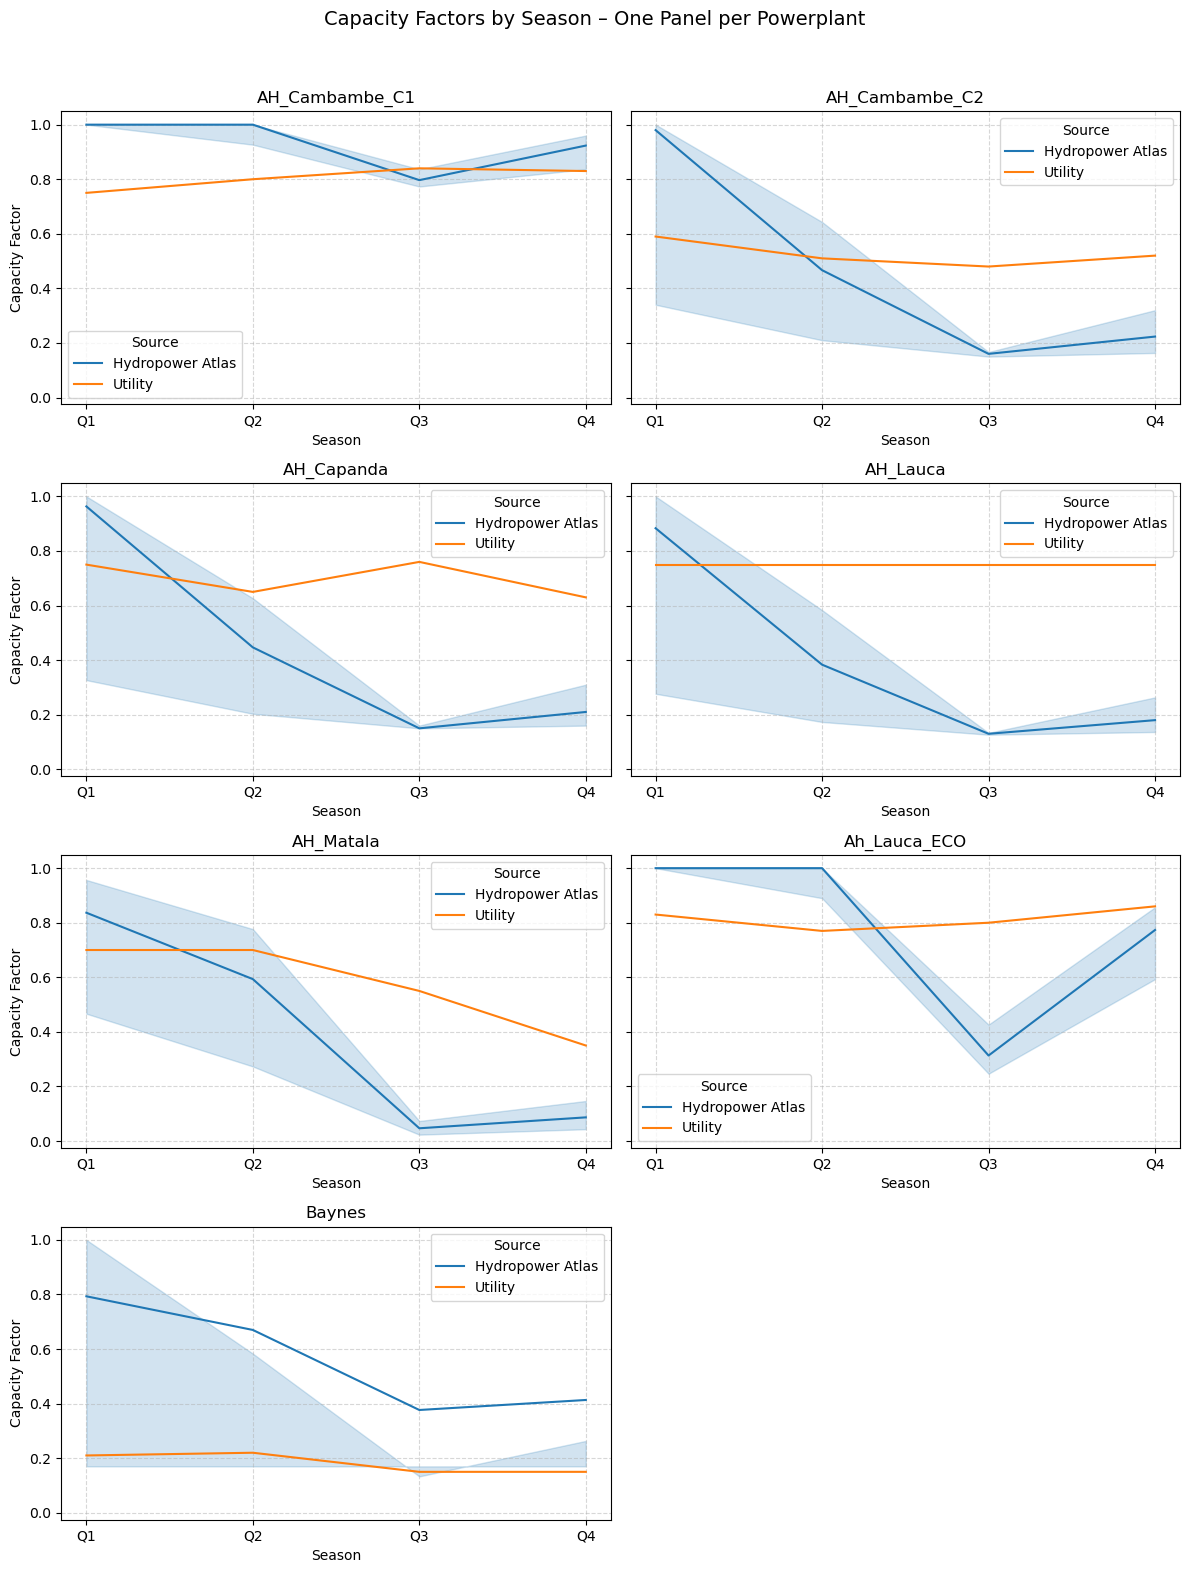

In [4]:
# Path to your file
csv_file = "input/Hydro comparison Angola.csv"

# Run the plot
plot_capacity_factors_by_plant(csv_file)
